모델 구조

[DW -> PW] -> [DW -> PW] -> Flatten -> Dense -> Dense

Size:

Input: (50-75)*6

DW_1: 5*6, padding: None, stride: 1, channels: 8

DW_2: 5*1, padding: None, stride: 1, channels: 16

Dense_1: nodes: 32

Dense_2: nodes: 6 output layer.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


In [3]:
INPUT_SIZE = 30
INPUT_CHANNELS = 6
OUTPUT_SIZE = 6



In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

# 예시 변수 설정 (실제 값으로 대체해야 함)
INPUT_SIZE = 30
INPUT_CHANNELS = 6
OUTPUT_SIZE = 6

def CreateMicroModel():
  # 정의된 이니셜라이저
  busy_initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)
  bias_init = tf.keras.initializers.RandomUniform(minval=0.1, maxval=0.5)

  input = layers.Input(shape=(INPUT_SIZE, INPUT_CHANNELS,1))
  #x = layers.Reshape((INPUT_SIZE, INPUT_CHANNELS, 1))(input)

  # block 1: Conv2D (일반 컨볼루션)
  dw_1 = layers.Conv2D(
      filters=8,
      kernel_size=(5,3),
      strides=(1,3),
      padding='valid',
      kernel_initializer=busy_initializer, # kernel_initializer 적용
      bias_initializer=bias_init          # bias_initializer 적용
  )(input)

  pw_1 = layers.ReLU()(dw_1)

  # block 2: DepthwiseConv2D (깊이별 컨볼루션)
  dw_2 = layers.DepthwiseConv2D(
      kernel_size=(5,2),
      strides=(1,1),
      padding='valid',
      depthwise_initializer=busy_initializer, # depthwise_initializer 적용
      bias_initializer=bias_init               # bias_initializer 적용
  )(pw_1)

  pw_2 = layers.Conv2D(
      filters=16,
      kernel_size=(1,1),
      strides=(1,1),
      padding='valid',
      kernel_initializer=busy_initializer, # Pointwise Conv2D에 적용
      bias_initializer=bias_init
  )(dw_2)
  pw_2 = layers.ReLU()(pw_2)

  # block 3: DepthwiseConv2D
  dw_3 = layers.DepthwiseConv2D(
      kernel_size=(5,1),
      strides=(1,1),
      padding='valid',
      depthwise_initializer=busy_initializer, # depthwise_initializer 적용
      bias_initializer=bias_init               # bias_initializer 적용
  )(pw_2)

  #pw_3 = layers.Conv2D(
  #    filters=32,
  #    kernel_size=(1,1),
  #    strides=(1,1),
  #    padding='valid',
  #    kernel_initializer=busy_initializer, # Pointwise Conv2D에 적용
  #    bias_initializer=bias_init
  #)(dw_3)
  #pw_3 = layers.ReLU()(pw_3)

  # FLAT & Dense
  #flat= layers.Reshape((-1,32))(pw_3)
  flat = layers.AveragePooling2D(pool_size=(22,1),strides=(1,1),padding="valid")(pw_2)
  flat = layers.Flatten()(flat)

  de_1 = layers.Dense(
      units=32,
      activation='relu',
      kernel_initializer=busy_initializer, # Dense 레이어에 적용
      bias_initializer=bias_init
  )(flat)

  out = layers.Dense(
      units=OUTPUT_SIZE,
      activation='softmax',
      kernel_initializer=busy_initializer, # Dense 레이어에 적용
      bias_initializer=bias_init
  )(de_1)

  return keras.Model(inputs=input, outputs=out)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, initializers

def CreateMicroModel_Benchmark_WorstCase():
    # 1. 0이 나올 확률이 거의 없는 '균등 분포' 초기화 설정
    # -0.5 ~ 0.5 사이의 난수로 가중치를 꽉 채움
    # seed를 고정하지 않으면 매번 다른 난수가 생성되어 더욱 'Random'해짐
    busy_initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5)

    # 편향(Bias)도 0이면 연산이 단순해질 수 있으므로 난수로 채움
    bias_init = initializers.RandomUniform(minval=0.1, maxval=0.5)

    input = layers.Input(shape=(INPUT_SIZE, INPUT_CHANNELS))
    x = layers.Reshape((-1, INPUT_CHANNELS, 1))(input)

    # --- Block 1 ---
    dw_1 = layers.DepthwiseConv2D(
        kernel_size=(5, 3), strides=(1, 3), padding='valid',
        depthwise_initializer=busy_initializer, # [중요] 가중치 강제 주입
        use_bias=True, bias_initializer=bias_init
    )(x)

    pw_1 = layers.Conv2D(
        filters=16, kernel_size=(1, 1), strides=(1, 1), padding='valid',
        kernel_initializer=busy_initializer,    # [중요] 가중치 강제 주입
        use_bias=True, bias_initializer=bias_init
    )(dw_1)

    # ReLU는 Activation이 0이 되게 만들지만, 이건 실제 동작에서도 발생하는 부하여서 그대로 둠
    x = layers.ReLU()(pw_1)

    # --- Block 2 ---
    dw_2 = layers.DepthwiseConv2D(
        kernel_size=(5, 2), strides=(1, 1), padding='valid',
        depthwise_initializer=busy_initializer,
        use_bias=True, bias_initializer=bias_init
    )(x)

    pw_2 = layers.Conv2D(
        filters=32, kernel_size=(1, 1), strides=(1, 1), padding='valid',
        kernel_initializer=busy_initializer,
        use_bias=True, bias_initializer=bias_init
    )(dw_2)
    x = layers.ReLU()(pw_2)

    # --- Block 3 ---
    dw_3 = layers.DepthwiseConv2D(
        kernel_size=(5, 1), strides=(1, 1), padding='valid',
        depthwise_initializer=busy_initializer,
        use_bias=True, bias_initializer=bias_init
    )(x)

    pw_3 = layers.Conv2D(
        filters=64, kernel_size=(1, 1), strides=(1, 1), padding='valid',
        kernel_initializer=busy_initializer,
        use_bias=True, bias_initializer=bias_init
    )(dw_3)
    x = layers.ReLU()(pw_3)

    # --- Classification ---
    x = layers.Reshape((-1, 64))(x)
    flat = layers.GlobalAveragePooling1D()(x)

    de_1 = layers.Dense(
        units=64, activation='relu',
        kernel_initializer=busy_initializer, # Dense층도 가중치 꽉 채움
        bias_initializer=bias_init
    )(flat)

    out = layers.Dense(
        units=OUTPUT_SIZE, activation='softmax',
        kernel_initializer=busy_initializer
    )(de_1)

    return models.Model(inputs=input, outputs=out)

In [6]:
model = CreateMicroModel()
model.summary()
model2 = CreateMicroModel_Benchmark_WorstCase()
model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 6, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 2, 8)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 26, 2, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 22, 1, 8)       │            88 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 1, 16)      │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 22, 1, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,102 (4.30 KB)

 Trainable params: 1,102 (4.30 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 30, 6, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 26, 2, 1)       │            16 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 2, 16)      │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 26, 2, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_3              │ (None, 22, 1, 16)      │           176 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 1, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 22, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_4              │ (None, 18, 1, 32)      │           192 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 1, 64)      │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 18, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 18, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,622 (29.77 KB)

 Trainable params: 7,622 (29.77 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

model2.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

In [8]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter2 = tf.lite.TFLiteConverter.from_keras_model(model2)

tm = converter.convert()
t2m = converter2.convert()

converter.optimizations = [tf.lite.Optimize.DEFAULT]

Saved artifact at '/tmp/tmp5re4oky4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 6, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136765156885904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136764875412240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762475070480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762475072016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762477887120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762475073552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762475074320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762475074512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762475074704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762475071824: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved artifact at '

# Task
Prepare the `model` for Int8 quantization by setting `converter.representative_dataset` with a dummy dataset of the correct input shape, then generate the Int8 TFLite model, and convert it into an Arduino-compatible C array.

## Prepare Model for Quantization

### Subtask:
모델을 Int8 양자화하기 위해 준비합니다. 이를 위해서는 모델이 학습된 후 대표 데이터셋을 제공하여 양자화 범위를 보정해야 합니다. 현재 학습된 데이터가 없으므로 임의의 더미 데이터를 생성하여 이 단계를 진행합니다. 이 단계에서는 `converter.representative_dataset`을 설정합니다.


**Reasoning**:
Define a generator function `representative_data_gen` that creates a dummy input tensor with the specified shape and data type, and then assign this function to `converter.representative_dataset` to prepare for quantization.



In [9]:
import numpy as np

def representative_data_gen():
  for _ in range(1):
    data = np.random.rand(1, INPUT_SIZE, INPUT_CHANNELS,1).astype(np.float32)
    yield [data]

converter.representative_dataset = representative_data_gen
print("converter.representative_dataset has been set.")

converter.representative_dataset has been set.


## Convert to Int8 TFLite Model

### Subtask:
준비된 모델과 대표 데이터셋을 사용하여 `tf.lite.Optimize.DEFAULT` 옵션과 `tf.int8` 타겟 타입을 설정하여 TFLiteConverter를 통해 Int8로 양자화된 TFLite 모델을 생성합니다. 이 과정에서 `converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]`와 `converter.inference_input_type = tf.int8`, `converter.inference_output_type = tf.int8`을 설정합니다.


**Reasoning**:
To prepare for Int8 quantization, I will configure the TFLite converter with default optimizations, specify INT8 as the target operation set, and set both input and output inference types to INT8. Finally, I will convert the model.



In [10]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()
print("Int8 quantized TFLite model generated successfully.")

Saved artifact at '/tmp/tmplczfjoso'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 6, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136765156885904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136764875412240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762475070480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762475072016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762477887120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762475073552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762475074320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762475074512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762475074704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136762475071824: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Int8 quantized TFLite model generated successfully.


**Reasoning**:
To create an Arduino-compatible C array, the generated Int8 TFLite model needs to be saved to a file, and then converted into a C header file format using a command-line utility like `xxd`.



In [11]:
import os

# Save the quantized model to a .tflite file
model_name = "quantized_model_int8.tflite"
with open(model_name, "wb") as f:
    f.write(tflite_quant_model)
print(f"Int8 quantized TFLite model saved as {model_name}")

# Convert the .tflite file to a C array using xxd
header_name = "model_data.h"
os.system(f"xxd -i {model_name} > {header_name}")
print(f"Model converted to C array in {header_name}")


Int8 quantized TFLite model saved as quantized_model_int8.tflite
Model converted to C array in model_data.h


In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split

def load_from_file(filepath):
  with open(filepath, 'r') as f:
    try:
      datas = json.load(f)
      raw = datas['working_set']
    except json.JSONDecodeError as e:
      f.seek(0)
      raw = [json.loads(line) for line in f]

  x = []
  y = []

  for item in raw:
    frame = item['frame']
    label = item['label']
    x.append(frame)
    y.append(label)

  #input is int8.

  X = np.array(x, dtype=np.float32) # Rescaling with internal.
  X = np.expand_dims(X, axis=3)
  Y = np.array(y, dtype=np.int16)

  return X,Y


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

# 예시 변수 설정 (실제 값으로 대체해야 함)
INPUT_SIZE = 30
INPUT_CHANNELS = 6
OUTPUT_SIZE = 6

def CreateMicroModel():
  # 정의된 이니셜라이저

  input = layers.Input(shape=(INPUT_SIZE, INPUT_CHANNELS,1), dtype='float32')

  #rescaled = tf.keras.layers.Rescaling(scale=1/127.0)(input)
  #x = layers.Reshape((INPUT_SIZE, INPUT_CHANNELS, 1))(input)

  # block 1: Conv2D (일반 컨볼루션)
  dw_1 = layers.Conv2D(
      filters=8,
      kernel_size=(5,3),
      strides=(1,3),
      padding='valid',
  )(input)

  pw_1 = layers.ReLU()(dw_1)

  # block 2: DepthwiseConv2D (깊이별 컨볼루션)
  dw_2 = layers.DepthwiseConv2D(
      kernel_size=(5,2),
      strides=(1,1),
      padding='valid',
  )(pw_1)

  pw_2 = layers.Conv2D(
      filters=16,
      kernel_size=(1,1),
      strides=(1,1),
      padding='valid',
  )(dw_2)
  pw_2 = layers.ReLU()(pw_2)

  # block 3: DepthwiseConv2D
  dw_3 = layers.DepthwiseConv2D(
      kernel_size=(5,1),
      strides=(1,1),
      padding='valid',
  )(pw_2)

  #pw_3 = layers.Conv2D(
  #    filters=32,
  #    kernel_size=(1,1),
  #    strides=(1,1),
  #    padding='valid',
  #    kernel_initializer=busy_initializer, # Pointwise Conv2D에 적용
  #    bias_initializer=bias_init
  #)(dw_3)
  #pw_3 = layers.ReLU()(pw_3)

  # FLAT & Dense
  #flat= layers.Reshape((-1,32))(pw_3)
  flat = layers.AveragePooling2D(pool_size=(22,1),strides=(1,1),padding="valid")(pw_2)
  flat = layers.Flatten()(flat)

  de_1 = layers.Dense(
      units=32,
      activation='relu',
  )(flat)

  out = layers.Dense(
      units=OUTPUT_SIZE,
      activation='softmax',
  )(de_1)

  return keras.Model(inputs=input, outputs=out)

filename = "data.json"

XX, YY = load_from_file(filename)

categorical_YY = tf.keras.utils.to_categorical(YY, num_classes=6)

print(f"Shape = {XX.shape}")

model = CreateMicroModel()
model.summary()

def stratified_time_split(X, y, train_ratio=0.6, val_ratio=0.2):
    """
    각 라벨별로 시간 순서를 유지하며 데이터를 자른 뒤 합치는 함수
    구조: [Train (60%) | Val (20%) | Test (20%)]
    """
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    # 고유한 라벨들 (0, 1, 2, 3, 4, 5)
    classes = np.unique(y)

    for cls in classes:
        # 해당 라벨의 데이터 인덱스만 추출 (시간 순서대로 정렬되어 있다고 가정)
        cls_indices = np.where(y == cls)[0]

        n_total = len(cls_indices)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)

        # 인덱스 슬라이싱 (Shuffle 절대 금지!)
        # 앞부분 -> Train
        train_idx = cls_indices[:n_train]
        # 중간 -> Val
        val_idx = cls_indices[n_train : n_train + n_val]
        # 뒷부분 -> Test
        test_idx = cls_indices[n_train + n_val:]

        # 데이터 분배
        X_train.append(X[train_idx])
        y_train.append(y[train_idx])

        X_val.append(X[val_idx])
        y_val.append(y[val_idx])

        X_test.append(X[test_idx])
        y_test.append(y[test_idx])

    # 리스트 병합 및 Numpy 변환
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_val = np.concatenate(X_val)
    y_val = np.concatenate(y_val)

    X_test = np.concatenate(X_test)
    y_test = np.concatenate(y_test)

    return X_train, y_train, X_val, y_val, X_test, y_test

# --- 분할 실행 ---
train_X, train_y_raw, val_X, val_y_raw, test_X, test_y_raw = stratified_time_split(XX, YY)

# --- One-Hot Encoding (여기서 수행) ---
# 모델 출력층이 Softmax이므로 원-핫 인코딩 필요
num_classes = 6
train_Y = tf.keras.utils.to_categorical(train_y_raw, num_classes)
val_Y = tf.keras.utils.to_categorical(val_y_raw, num_classes)
test_Y = tf.keras.utils.to_categorical(test_y_raw, num_classes)

# --- 셔플 (Train 셋 내부에서는 섞어도 됨!) ---
# 학습 효율을 위해 Train 데이터 내에서는 순서를 섞어줍니다. (Val/Test와는 이미 분리됨)
indices = np.arange(train_X.shape[0])
np.random.shuffle(indices)
train_X = train_X[indices]
train_Y = train_Y[indices]

print("-" * 30)
print(f"🔹 Train Shape: {train_X.shape}")
print(f"🔹 Val   Shape: {val_X.shape}")
print(f"🔹 Test  Shape: {test_X.shape}")
print("-" * 30)




Shape = (4818, 30, 6, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 6, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 2, 8)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 26, 2, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 22, 1, 8)       │            88 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 1, 16)      │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 22, 1, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,102 (4.30 KB)

 Trainable params: 1,102 (4.30 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------
🔹 Train Shape: (2888, 30, 6, 1)
🔹 Val   Shape: (961, 30, 6, 1)
🔹 Test  Shape: (969, 30, 6, 1)
------------------------------


In [6]:
model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

model.fit(train_X, train_Y, epochs=15, validation_data=(val_X, val_Y))

print("EVULATE")

model.evaluate(test_X, test_Y)

Epoch 1/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9224 - loss: 0.2254 - val_accuracy: 0.7940 - val_loss: 0.8313
Epoch 2/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9327 - loss: 0.2099 - val_accuracy: 0.7659 - val_loss: 1.0395
Epoch 3/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9427 - loss: 0.1937 - val_accuracy: 0.7773 - val_loss: 0.9543
Epoch 4/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9360 - loss: 0.1964 - val_accuracy: 0.7638 - val_loss: 1.0366
Epoch 5/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9516 - loss: 0.1693 - val_accuracy: 0.7992 - val_loss: 0.9569
Epoch 6/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9410 - loss: 0.1842 - val_accuracy: 0.7773 - val_loss: 1.0246
Epoch 7/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9452 - loss: 0.1684 - val_accuracy: 0.7784 - val_loss: 1.0756
Epoch 8/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9631 - loss: 0.1291 - val_accuracy: 0.7940 - val_los

[1.1062939167022705, 0.7729617953300476]

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


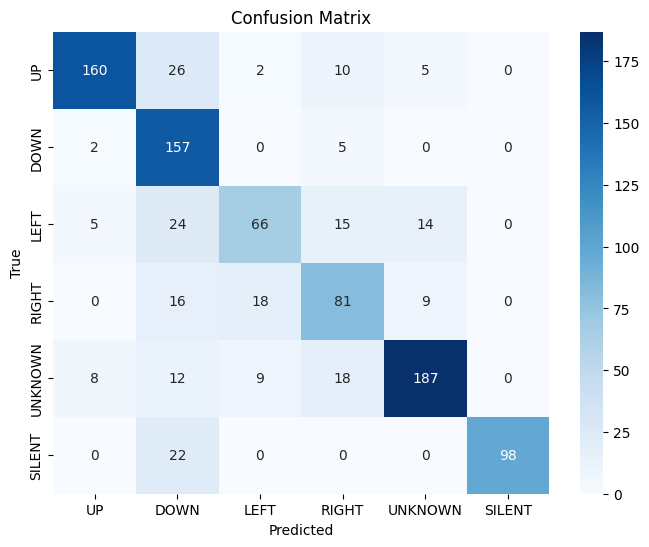

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

# 모델 예측
y_pred = model.predict(test_X)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_Y, axis=1) # One-hot -> Index 변환

# 혼동 행렬 생성
cm = confusion_matrix(y_true, y_pred_classes)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["UP", "DOWN", "LEFT", "RIGHT", "UNKNOWN", "SILENT"], yticklabels=["UP", "DOWN", "LEFT", "RIGHT", "UNKNOWN", "SILENT"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [13]:

def create_dummy_dataset():
  dummy = np.zeros((1,30,6,1), dtype=np.float32)
  dummy[0, :, 0] = -128.0
  dummy[0, :, 1] = 127.0

  yield [dummy]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tm = converter.convert()

converter.representative_dataset = create_dummy_dataset

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quant_model = converter.convert()
print("Int8 quantized TFLite model generated successfully.")

with open("quantized_model_int8.tflite", "wb") as f:
  f.write(tflite_quant_model)

Saved artifact at '/tmp/tmpmlkis7ab'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 6, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135229707217104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135229707218448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135229707219600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135229707219408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135229707219984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135229707218256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135229707222480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135229707222288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135229707222864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135229431448784: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved artifact at '

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [14]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zp = input_details[0]['quantization']
output_scale, output_zp = output_details[0]['quantization']

print("Model Status: ")
print(f"Input Scale: {input_scale}, Input Zero Point: {input_zp}")
print(f"Output Scale: {output_scale}, Output Zero Point: {output_zp}")

Model Status: 
Input Scale: 1.0, Input Zero Point: 0
Output Scale: 0.00390625, Output Zero Point: -128


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [15]:
!xxd -i quantized_model_int8.tflite > model_data.h

## Final Task

### Subtask:
Int8 압축 TFLite 모델과 Arduino에서 사용할 수 있는 C 배열 파일을 생성하는 과정을 완료하고, 다음 단계에 대한 안내를 제공합니다.


## Summary:

### Data Analysis Key Findings

*   A dummy `float32` dataset of shape `(1, INPUT_SIZE, INPUT_CHANNELS)` was successfully created using `numpy.random.rand` and assigned to `converter.representative_dataset` to prepare the model for Int8 quantization.
*   The `TFLiteConverter` was configured with default optimization, `tf.lite.OpsSet.TFLITE_BUILTINS_INT8`, and `tf.int8` for both input and output inference types, successfully generating an Int8 quantized TFLite model.
*   The generated Int8 TFLite model was saved as `quantized_model_int8.tflite`.
*   The `.tflite` model was subsequently converted into an Arduino-compatible C array and saved as `model_data.h` using the `xxd` command.
*   During the conversion to the Int8 TFLite model, a `UserWarning` was issued: "Statistics for quantized inputs were expected, but not specified; continuing anyway."

### Insights or Next Steps

*   Investigate the `UserWarning` regarding missing input statistics. Although the conversion completed, providing actual representative data or explicitly defining input statistics (e.g., min/max ranges) could lead to more accurate quantization and improved model performance on the target hardware.
*   The next step is to integrate the generated `model_data.h` into an Arduino project and test the inference performance and accuracy of the Int8 quantized model on the Arduino platform.
